In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from pandas import DataFrame , concat
from sklearn.metrics import mean_absolute_error , mean_squared_error

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation

from sklearn.preprocessing import LabelEncoder

#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
from numpy import array , hstack
from tensorflow import keras
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from warnings import simplefilter
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
from keras_self_attention import SeqSelfAttention

In [ ]:
!pip install keras-self-attention

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv('/content/drive/MyDrive/Data/dataTS.csv', 
                   usecols = ['Time', 'pH', 'DO', 'TSS', 'TN', 'TP', 'TOC', 'ORP', 'Temp',
       'TEMP'], index_col= 'Time', parse_dates=['Time']).reindex(columns=['pH', 'DO', 'TSS', 'TN', 'TP', 'TOC', 'ORP', 'Temp',
       'TEMP'])
# data["Date_time"] = data.index.strftime('%H:%M:%S')
# data["Month"] = data.index.month
# data["Day"] = data.index.day
# for colname in data.select_dtypes(["object", "category"]):
#     data[colname], _ = data[colname].factorize()

In [6]:
data_train, data_test = train_test_split(
    data, test_size= 100, shuffle=False)
data_train, data_val = train_test_split(
    data_train, test_size= 100, shuffle=False)

In [7]:
def generate_input_output_pairs(data, time_steps, target_steps):
    X = []
    y = []
    for i in range(len(data) - time_steps - target_steps + 1):
        X.append(data[i:i+time_steps,:])
        y.append(data[i+time_steps:i+time_steps+target_steps,:])
    return np.array(X), np.array(y)

In [8]:
X_train, y_train = generate_input_output_pairs(data_train.values, time_steps=20, target_steps=10)
X_val, y_val = generate_input_output_pairs(data_val.values, time_steps=20, target_steps=10)
X_test, y_test = generate_input_output_pairs(data_test.values, time_steps=20, target_steps=10)
# Add noise to data
noise_factor = 0.05
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)

In [9]:
# Define the number of features and time steps
num_features = 9
time_steps = 20
target_steps = 10

# Define the model
model = tf.keras.models.Sequential([
    # Encoder LSTM
    # tf.keras.layers.Normalization(input_shape=(time_steps, num_features)),
    tf.keras.layers.LSTM(32, input_shape=(time_steps, num_features),activation='relu', return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.LSTM(32, return_sequences=True),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.LSTM(1, activation='relu'),
    tf.keras.layers.RepeatVector(target_steps),
    SeqSelfAttention(attention_activation='softmax'),
    
    # Decoder LSTM
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, return_sequences=True),
    
    # Output layer
    tf.keras.layers.TimeDistributed(Dense(num_features))
])

# Compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5376      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 10, 32)           0         
 )                                                               
                                                                 
 seq_self_attention (SeqSelf  (None, 10, 32)           2113      
 Attention)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 10, 32)            8320      
                                                                 
 dropout_1 (Dropout)         (None, 10, 32)            0

In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit([X_train_noisy], [y_train],
                    validation_data=([X_val], [y_val]), 
                          batch_size=256, 
                          epochs=50, 
                          verbose=1, callbacks=[callback])

Epoch 1/50
1325/1325 [==============================] - 124s 87ms/step - loss: 22563.1094 - val_loss: 11294.3604
Epoch 2/50
1325/1325 [==============================] - 113s 85ms/step - loss: 16782.1680 - val_loss: 6902.8281
Epoch 3/50
1325/1325 [==============================] - 112s 84ms/step - loss: 13277.3701 - val_loss: 4204.3862
Epoch 4/50
1325/1325 [==============================] - 133s 101ms/step - loss: 10876.1152 - val_loss: 2580.4690
Epoch 5/50
1325/1325 [==============================] - 115s 86ms/step - loss: 8898.6631 - val_loss: 2210.2888
Epoch 6/50
1325/1325 [==============================] - 117s 89ms/step - loss: 7603.1870 - val_loss: 2169.1423
Epoch 7/50
1325/1325 [==============================] - 113s 85ms/step - loss: 6647.2632 - val_loss: 2301.6333
Epoch 8/50
1325/1325 [==============================] - 116s 88ms/step - loss: 5787.0737 - val_loss: 3017.1887
Epoch 9/50
1325/1325 [==============================] - 115s 87ms/step - loss: 5074.5908 - val_loss: 2470.

In [11]:
y_pred = model.predict(X_test)
np.save('lstm_autoencoder_attention.npy', y_pred)

3/3 [==============================] - 1s 10ms/step


In [12]:
for i,j in zip(range(9),['pH', 'DO', 'TSS', 'TN', 'TP', 'TOC', 'ORP', 'Temp', 'TEMP']):
  print(j,' RMSE ',mean_squared_error(y_pred.reshape(-1,9)[:,i], y_test.reshape(-1,9)[:,i], squared = False))
  print(j,' MAE ',mean_absolute_error(y_pred.reshape(-1,9)[:,i], y_test.reshape(-1,9)[:,i]))

pH  RMSE  5.27045028495225
pH  MAE  5.2625252771243245
DO  RMSE  2.0173459899643937
DO  MAE  2.002156297468803
TSS  RMSE  113.43243257659498
TSS  MAE  90.77236994297586
TN  RMSE  1.7307821689716105
TN  MAE  1.4144497421310984
TP  RMSE  59.13524478319686
TP  MAE  44.81330864238877
TOC  RMSE  9.377185697974463
TOC  MAE  7.486306711800865
ORP  RMSE  53.14262084870467
ORP  MAE  47.19490485392826
Temp  RMSE  2.3612356911824404
Temp  MAE  1.9785703549452234
TEMP  RMSE  4.605434361342951
TEMP  MAE  3.757697239352599


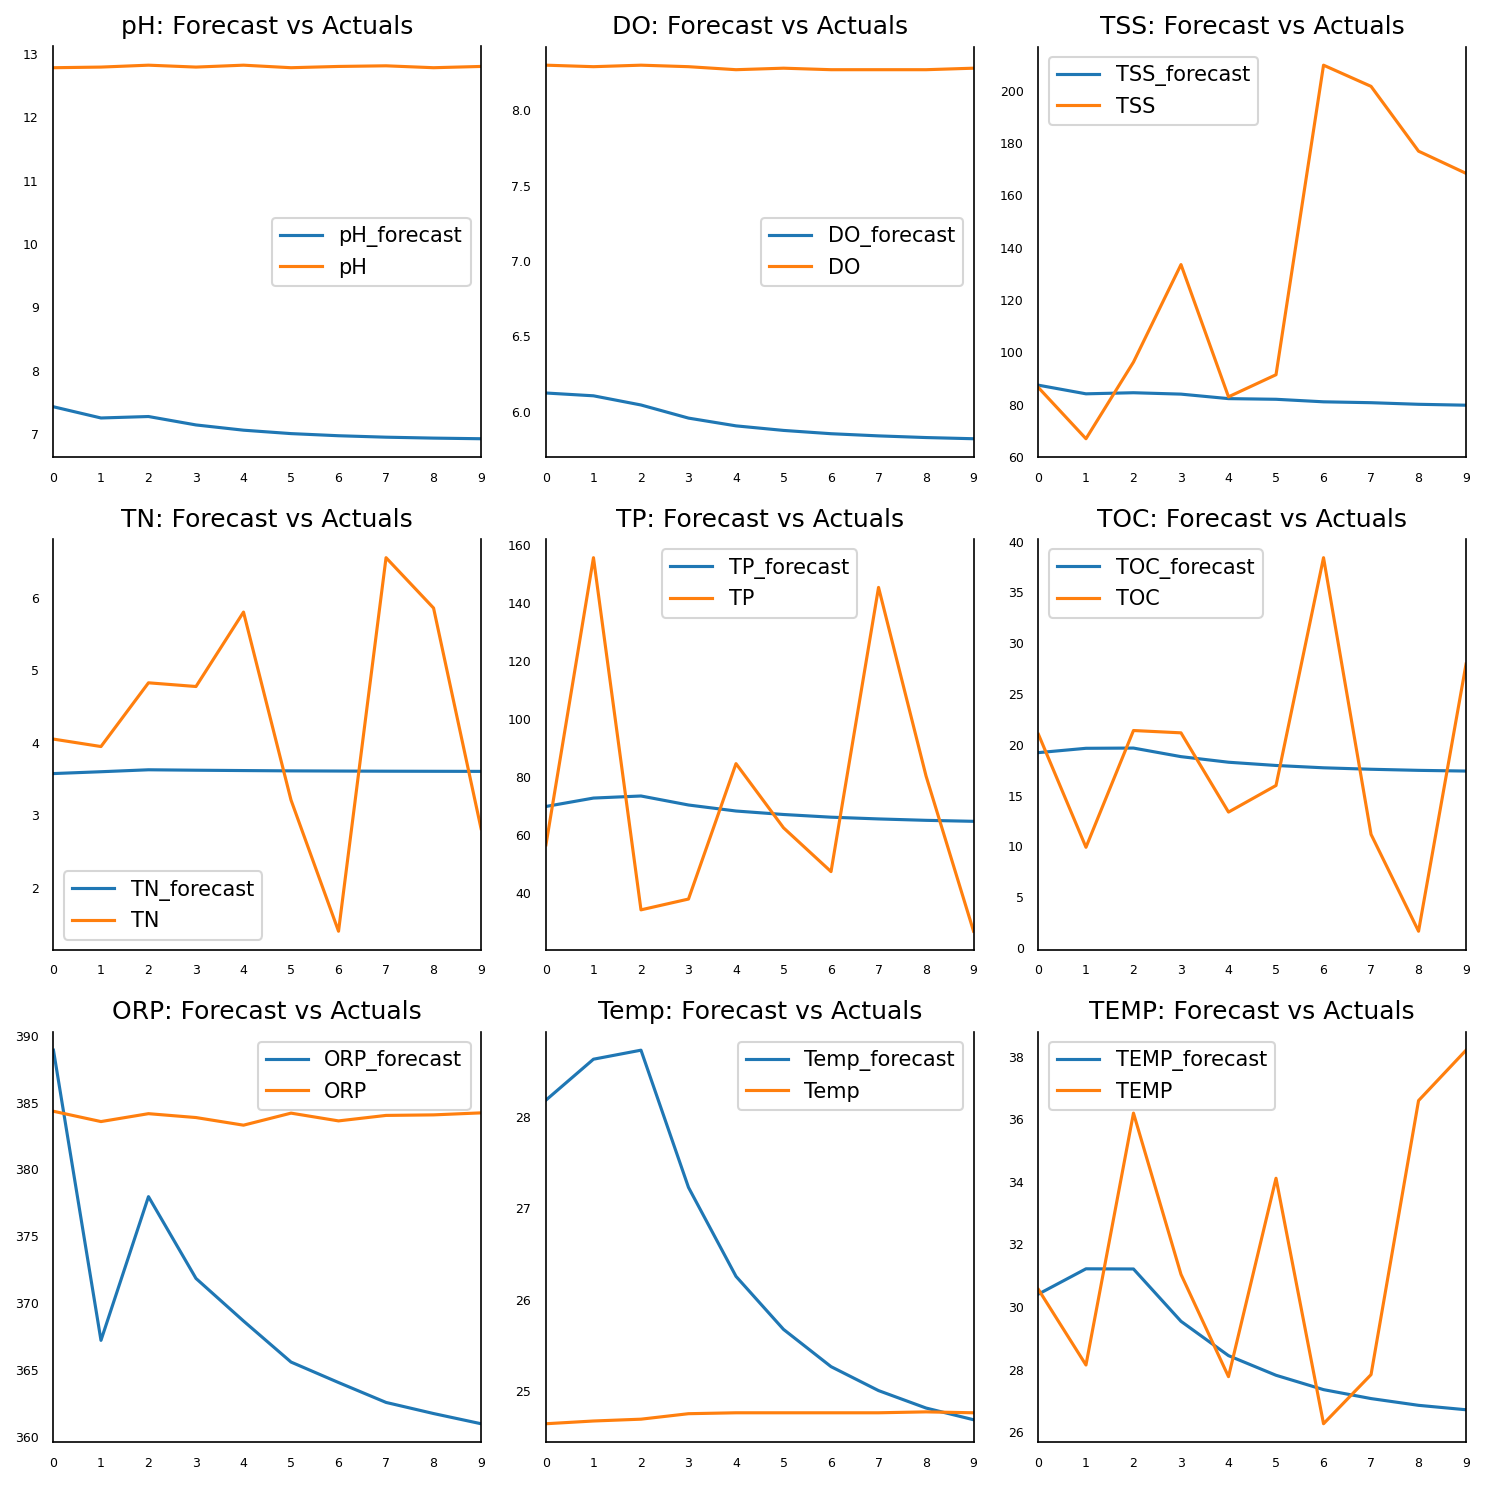

In [15]:
fig, axes = plt.subplots(nrows=int(len(data.columns)/3), ncols=3, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
    df_results = pd.DataFrame({f'{col}_forecast': y_pred[-1][:,i]})
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test = pd.DataFrame({f'{col}': y_test[-1][:,i]})
    df_test[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout(); 

#LSTM 

In [16]:
num_features = 9
time_steps = 20
target_steps = 10
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(time_steps, num_features), return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(tf.keras.layers.RepeatVector(target_steps))
model.add(tf.keras.layers.TimeDistributed(Dense(num_features)))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 20, 64)            18944     
                                                                 
 dropout_2 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 10, 32)           0         
 or)                                                             
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 9)            297       
 tributed)                                                       
                                                                 
Total params: 31,657
Trainable params: 31,657
Non-trai

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit([X_train_noisy], [y_train],
                    validation_data=([X_val], [y_val]), 
                          batch_size=256, 
                          epochs=50, 
                          verbose=1, callbacks=[callback])

Epoch 1/50
1325/1325 [==============================] - 150s 107ms/step - loss: 13120.4678 - val_loss: 2382.6106
Epoch 2/50
1325/1325 [==============================] - 132s 100ms/step - loss: 3109.5498 - val_loss: 1971.3112
Epoch 3/50
1325/1325 [==============================] - 133s 101ms/step - loss: 3063.9631 - val_loss: 2098.7722
Epoch 4/50
1325/1325 [==============================] - 131s 99ms/step - loss: 2889.6438 - val_loss: 2519.5164
Epoch 5/50
1325/1325 [==============================] - 133s 100ms/step - loss: 2260.3713 - val_loss: 2589.0073
Epoch 6/50
1325/1325 [==============================] - 129s 98ms/step - loss: 2164.6953 - val_loss: 2481.6194
Epoch 7/50
1325/1325 [==============================] - 133s 100ms/step - loss: 2124.2107 - val_loss: 2542.2800


In [18]:
y_pred = model.predict(X_test)
np.save('lstm.npy', y_pred)

3/3 [==============================] - 0s 10ms/step


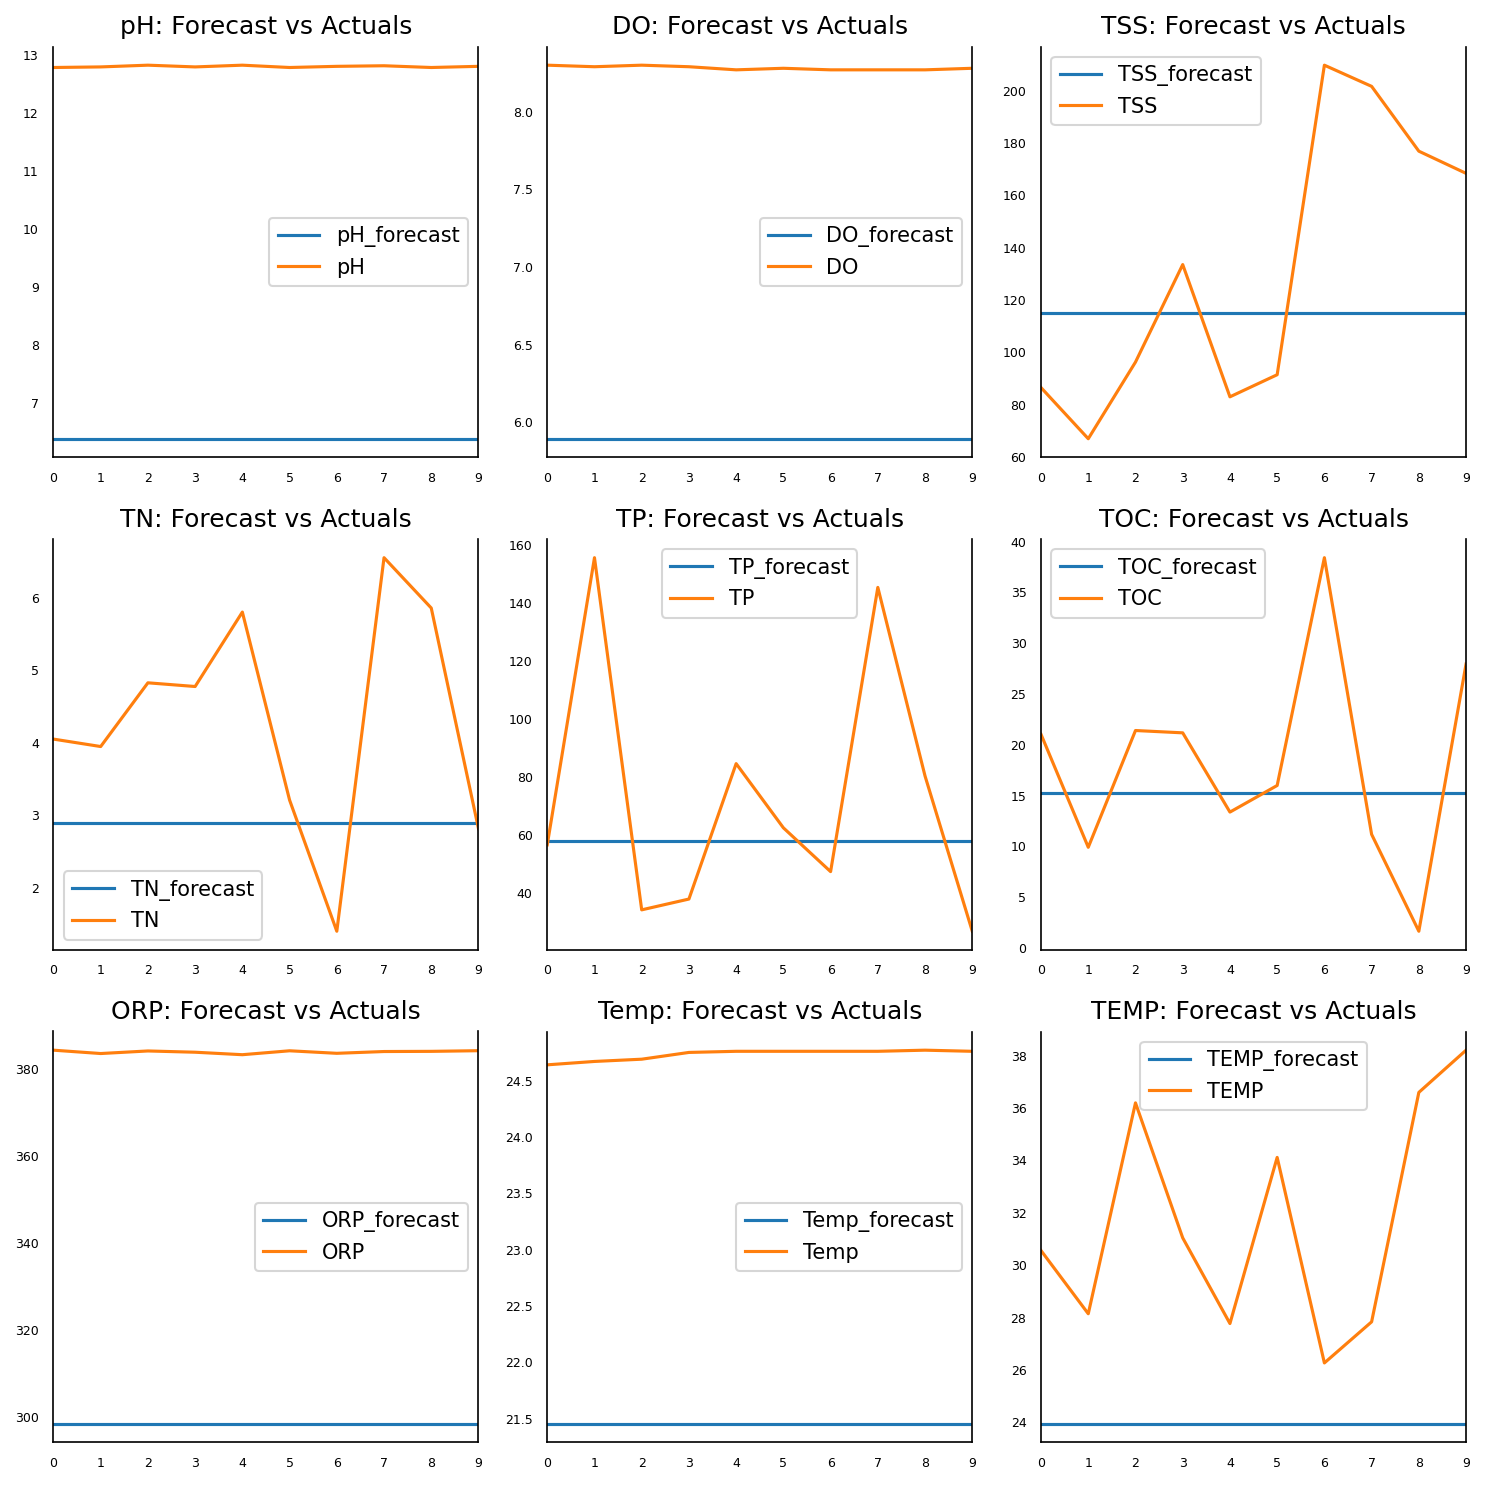

In [19]:
fig, axes = plt.subplots(nrows=int(len(data.columns)/3), ncols=3, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
    df_results = pd.DataFrame({f'{col}_forecast': y_pred[-1][:,i]})
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test = pd.DataFrame({f'{col}': y_test[-1][:,i]})
    df_test[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout(); 

In [20]:
for i,j in zip(range(9),['pH', 'DO', 'TSS', 'TN', 'TP', 'TOC', 'ORP', 'Temp', 'TEMP']):
  print(j,' RMSE ',mean_squared_error(y_pred.reshape(-1,9)[:,i], y_test.reshape(-1,9)[:,i], squared = False))
  print(j,' MAE ',mean_absolute_error(y_pred.reshape(-1,9)[:,i], y_test.reshape(-1,9)[:,i]))

pH  RMSE  6.548325037024983
pH  MAE  6.526300627802461
DO  RMSE  2.880447410921593
DO  MAE  2.8539309987350245
TSS  RMSE  111.2605522533075
TSS  MAE  89.32831661288515
TN  RMSE  1.9840847052701684
TN  MAE  1.667260672693071
TP  RMSE  61.285757190260234
TP  MAE  41.74946056977104
TOC  RMSE  10.322942755187594
TOC  MAE  8.269042023931949
ORP  RMSE  75.44138747167811
ORP  MAE  72.33007847573722
Temp  RMSE  5.356804963874937
Temp  MAE  5.008427482712437
TEMP  RMSE  9.031165462355638
TEMP  MAE  7.770471795010589
